In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
from fastprogress import master_bar, progress_bar

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from  torch.utils.data import DataLoader, Dataset
import torch.optim.lr_scheduler as lr_scheduler
# from CenterLoss import CenterLoss
from torch.autograd.function import Function

from sklearn.model_selection import KFold
from sklearn.metrics import recall_score

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
SEED = 2020
EPOCH = 5
IMG_SIZE = 128
NUM_CLASSES = 10
BATCH_SIZE = 128  # 28だとFeature Mapの出力が 512 x 1 x 1となってしまい、Grad-CAMがうまく動作しない

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(SEED)

In [4]:
class MnistDataset(Dataset):
    
    def __init__(self, df, n_channels=1, is_train=True, transforms=None):
        self.data = df.iloc[:, 1:].values
#         self.fnames = df['image_id'].values
        self.n_channels = n_channels
        self.labels = df['label'].values
        self.transforms = transforms
        self.is_train = is_train
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx, :].reshape(28, 28).astype(np.uint8)
        image = (image*(255.0/image.max())).astype(np.uint8)
        image = cv2.resize(image, dsize=(IMG_SIZE, IMG_SIZE))
        
        if self.transforms:
            if self.transforms.albumentations:
                aug = Augmentation().get_augmentation(self.transforms.albumentations)
                augmented = aug(image=image)
                image = augmented['image'].astype(np.float32)

        image = image.reshape(1, IMG_SIZE, IMG_SIZE).astype(np.float32)
        if self.n_channels > 1:
            image = np.concatenate([image for i in range(self.n_channels)], axis=0)

        if self.is_train:
            label = self.labels[idx]
            return image, label
        else:
            return image

In [5]:
train_df = pd.read_csv('../data/input/train.csv')

In [6]:
folds = pd.DataFrame(index=train_df.index.values)
folds['fold_0'] = 0

fold = KFold(n_splits=5, shuffle=True, random_state=SEED)
for fold_, (trn_idx, val_idx) in enumerate(fold.split(train_df)):
    folds.loc[val_idx, f'fold_{fold_}'] = 0.2
    folds.loc[trn_idx, f'fold_{fold_}'] = 0

In [7]:
fold_num = 0
x_trn = train_df[folds[f'fold_{fold_num}'] > 0]
x_val = train_df[folds[f'fold_{fold_num}'] == 0]

y_val = x_val['label']

In [8]:
train_dataset = MnistDataset(x_trn, n_channels=3, transforms=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

valid_dataset = MnistDataset(x_val, n_channels=3, transforms=None)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [9]:
# Model
model = models.resnet18().to(device)
model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)
model.fc = nn.Linear(in_features=512, out_features=NUM_CLASSES, bias=True).to(device)

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
sheduler = lr_scheduler.StepLR(optimizer, 20, gamma=0.8)

In [11]:
best_epoch = -1
best_val_score = -np.inf
mb = master_bar(range(EPOCH))

train_loss_list = []
val_loss_list = []
val_score_list = []

counter = 0

for epoch in mb:
    start_time = time.time()
    model.train()
    avg_loss = 0.

    for images, labels in progress_bar(train_loader, parent=mb):
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        preds = model(images.float())
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    train_loss_list.append(avg_loss)

    

    model.eval()
    valid_preds = np.zeros((len(valid_loader.dataset), NUM_CLASSES))
    avg_val_loss = 0.

    for i, (images, labels) in enumerate(valid_loader):
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        preds = model(images.float())

        loss = criterion(preds, labels)

        valid_preds[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] = preds.cpu().detach().numpy()
        avg_val_loss += loss.item() / len(valid_loader)

    val_score = recall_score(y_val, np.argmax(valid_preds, axis=1), average='macro')

    val_loss_list.append(avg_val_loss)
    val_score_list.append(val_score)
        
    elapsed = time.time() - start_time
    mb.write(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f} val_score: {val_score:.4f} time: {elapsed:.0f}s')

    if best_val_score < val_score:
        best_epoch = epoch + 1
        best_val_score = val_score
        best_valid_preds = valid_preds
        best_model = model.state_dict()
        counter = 0
        
    counter += 1
    if counter == 100:
        break

print('\n\n===================================\n')
print(f'CV: {best_val_score}\n')
print(f'BEST EPOCH: {best_epoch}')
print(f'BEST RECALL: {best_val_score}')
print('\n===================================\n\n')




CV: 0.9420794535767782

BEST EPOCH: 5
BEST RECALL: 0.9420794535767782





### Source: https://qiita.com/sasayabaku/items/fd8923cf0e769104cc95
### Source: https://github.com/eclique/pytorch-gradcam/blob/master/gradcam.ipynb

In [12]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [13]:
features_fn = nn.Sequential(*list(model.children())[:-2])
classifier_fn = nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()] + list(model.children())[-1:]))

In [14]:
model = model.eval()
model = model.to(device)

In [15]:
def GradCam(img, c, feature_fn, classifier_fn):
    feats = feature_fn(img)  # Feature Map(avgpoolの手前までの出力tensor)
    _, N, H, W = feats.size() # featsの出力size
    out = classifier_fn(feats)  # 分類機にかける
    c_score = out[0, c]  # 最終出力結果の最大スコアを取得
    grads = torch.autograd.grad(c_score, feats)  # c_scoreに格納されているgrad_fn（微分関数）にfeatsを代入して、勾配を計算
    w = grads[0][0].mean(-1).mean(-1)  # Global Average Pooling
    sal = torch.matmul(w, feats.view(N, H*W))  # 内積を計算  512 x (512, 16)
    sal = F.relu(sal)  # 負値を0に
    sal = sal.view(H, W).cpu().detach().numpy()  # 4 x 4に変換
    sal = np.maximum(sal, 0)
    return sal

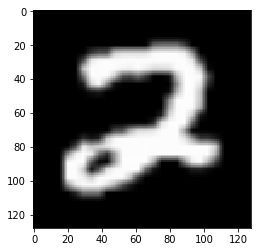

In [165]:
plt.imshow(valid_loader.dataset[126][0][0, :, :], cmap='gray')

In [162]:
input_index = 126
input_data = valid_loader.dataset[input_index][0]
input_data = torch.tensor(input_data.reshape(1, input_data.shape[0], input_data.shape[1], input_data.shape[2])).to(device)

In [163]:
pp, cc = torch.topk(nn.Softmax(dim=1)(model(input_data)), 3)
sal = GradCam(input_data.to(device), cc[0][2], features_fn, classifier_fn)
img = input_data.permute(0, 2, 3, 1).view(input_data.shape[2], input_data.shape[3], input_data.shape[1]).cpu().numpy()
img_sal = Image.fromarray(sal).resize(img.shape[0:2], resample=Image.LINEAR)

In [170]:
img = valid_loader.dataset[126][0][0, :, :]

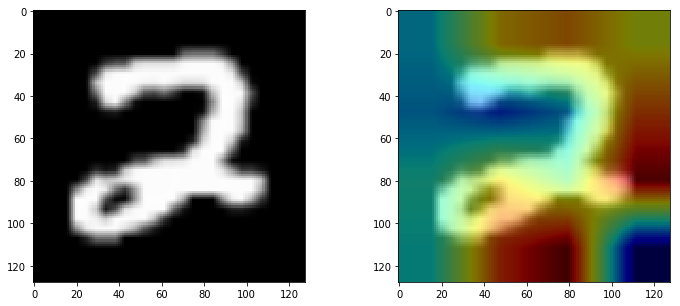

In [172]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(img, cmap='gray')

ax2.imshow(img, cmap='gray')
ax2.imshow(np.array(img_sal), alpha=0.5, cmap='jet')
# plt.colorbar()